# Did elimination of copayment increase visits to physicians?

In [1]:
# Import a package with tools (pandas) and call it pd
import pandas as pd

/opt/tljh/user/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/tljh/user/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Read the data into a dataframe called df
df = pd.read_csv('gp data.csv')

In [3]:
# Have a look at the data
df.head(8)

,Unnamed: 0,age,gender,year,visits,population
0,86,2,1,2006,49814,28361
1,87,2,1,2007,49077,28510
2,88,2,1,2008,50816,28592
3,89,2,1,2009,49637,29375
4,90,2,1,2010,52343,29333
5,91,2,1,2011,53314,30213
6,92,2,1,2012,55987,30948
7,93,2,1,2013,51309,30995


In [4]:
# create a variable showing visits per capita per year (in the different age groups)
df['visits_per_capita'] = df.visits/df.population

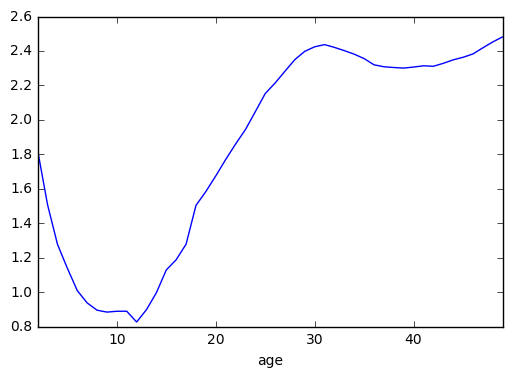

In [22]:
# plot the average number og visits in different age groups
%matplotlib inline
df.groupby('age')['visits_per_capita'].mean().plot()

In [23]:
#disable warnings (you should not do this when you work)
#import warnings
#warnings.filterwarnings('ignore')

In [15]:
df.head()

,Unnamed: 0,age,gender,year,visits,population,visits_per_capita
0,86,2,1,2006,49814,28361,1.756426
1,87,2,1,2007,49077,28510,1.721396
2,88,2,1,2008,50816,28592,1.777280
3,89,2,1,2009,49637,29375,1.689770
4,90,2,1,2010,52343,29333,1.784441


In [23]:
dfnew = df[['age', 'year', 'visits_per_capita']]

In [24]:
dfnew.head()

,age,year,visits_per_capita
0,2,2006,1.756426
1,2,2007,1.721396
2,2,2008,1.777280
3,2,2009,1.689770
4,2,2010,1.784441


In [25]:
dfnew = dfnew.set_index(['age', 'year'])

In [26]:
dfnew.head()

visits_per_capita
age year                   
2   2006           1.756426
    2007           1.721396
    2008           1.777280
    2009           1.689770
    2010           1.784441

In [27]:
dfnew.unstack('age')

ValueError: Index contains duplicate entries, cannot reshape

## Interrupted time design

In [6]:
# Did the number of visits to the physician change after 2010?
# simplify and select only one age and one gender
# put this data into a new dataframe called df14f 
# (dataframe with information about 14 year old females)

df14f = df.query('(age==14) & (gender==1)')

# create a variable to indicate whether it was before or after the reform
df14f['copay']=0
df14f.copay[df14f.year>2009] = 1

C:\Users\hmelberg_adm\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hmelberg_adm\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hmelberg_adm\Anaconda3\lib\site-packages\pandas\core\generic.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\hmelberg_adm\Anaconda3\lib\si

In [7]:
# run the interrupted time design model

import statsmodels.formula.api as smf

model = 'visits_per_capita ~ copay + year'

mod = smf.ols(model, data=df14f)
res = mod.fit()
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:      visits_per_capita   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     152.2
Date:                Fri, 03 Feb 2017   Prob (F-statistic):           3.32e-05
Time:                        14:46:10   Log-Likelihood:                 20.899
No. Observations:                   8   AIC:                            -35.80
Df Residuals:                       5   BIC:                            -35.56
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -56.8936     14.254     -3.991      0.0

C:\Users\hmelberg_adm\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


## Difference-in-Difference

The aim in now to compare the average number of visits before and after the reform for one group that was affected by the reform and one group who is as similar as possible, but unaffected. For instance: Compare 14 year olds (who are affected since they do no longer have to pay to visits the doctor after 2010) and 10 year olds (who are not affected since they never had to pay. In order to do so we first reshape the dataframe so it only includes 10 and 14 year olds (of one gender). MOreover we focus only on visits per capita in these age groups, and it would be convenien if each age group had a separate column (as opposd to being stacked on top of each other). So, before doing the calculations we will reshape and fix this.


In [8]:
#create a new dataframe (copies the old one)
df2 = df.set_index(['age', 'year'])
df2 = df2[df2.gender==1]

In [9]:
# focus on only one variable and unstack age 
df3 = df2['visits_per_capita'].copy()
df3 = df3.unstack('age')

In [10]:
# change the column names so there is a "age" in front of each number/age
cols = df3.columns.tolist()
cols2 = ['age'+str(x) for x in cols]
df3.columns = cols2

In [11]:
# create a new dataframe with only 10 and 14 year olds
dfsmall = df3[['age10', 'age14']]

In [12]:
# create a variable indicating whether something is before or after the reform
dfsmall['copay']='before'
dfsmall.copay[dfsmall.index>2009] = 'after'

C:\Users\hmelberg_adm\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\hmelberg_adm\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\hmelberg_adm\Anaconda3\lib\site-packages\pandas\core\generic.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  s

In [13]:
# get the average number og visits to the doctor before and after the reform for each age group
avg = dfsmall.groupby('copay').mean()
avg

,age10,age14
copay,,
after,0.944511,1.246069
before,0.865694,0.976641


In [14]:
# calculate the differences between the age groups
# and the difference between the difference before and after the reform
avg['difference'] = avg.age14 - avg.age10
avg.difference.after - avg.difference.before

0.19061068722838814

## Synthetic control

In the difference-in-difference model we compared the 14 year olds to the 10 year olds. We could have compared against 8,9, 10, 11, 17 or many other age groups. The idea behind synthetic control is that instead of just selecting one group, we allow the computer to select a combination of the other possible comparisons. We would like to select a comparsion with a good fit between out group (the 14 year olds) so we first run a regression to determin what combination of the other groups that best predict visits amoung 14 year olds.

                            OLS Regression Results                            
Dep. Variable:                  age14   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     2.062
Date:                Fri, 03 Feb 2017   Prob (F-statistic):              0.442
Time:                        15:05:06   Log-Likelihood:                 12.339
No. Observations:                   4   AIC:                            -18.68
Df Residuals:                       1   BIC:                            -20.52
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.7562      1.995      1.381      0.3

C:\Users\hmelberg_adm\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n))


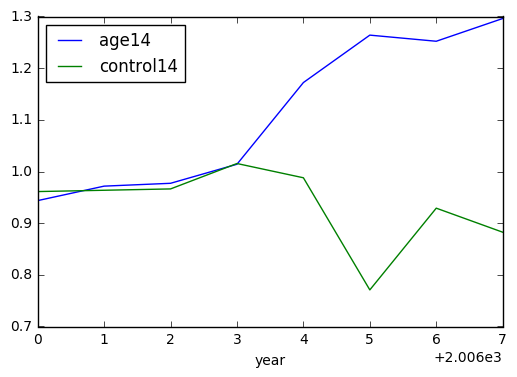

In [31]:
import statsmodels.formula.api as smf
model = 'age14 ~ age8 + age9'
mod = smf.ols(model, data=df3[df3.index<2010])
res = mod.fit()
print (res.summary())

# after determinig the importance of the other groups, 
# we use the results of the model to predic what the pattern 
# should be after the reform (if it follows the same pattern as previously)

df3['control14'] = res.predict(exog = df3)

# the difference between the predicted visits and observed visits (for 14 
# year olds) is the impact of the reform. We plot this.

df3[['age14', 'control14']].plot()

In [30]:
%matplotlib inline